# Inveralos de Confianza Práctica
Katlyn Goeujon-Mackness <br>
04/04/2025

## Objetivo
Obtener un intervalo de confianze en un modelo de regresión lineal múltiple tras determinar el conjunto de variables significativas más adecuado. Al terminar este proceso, deberás validar los supuestos necesarios para tener un modelo robusto.

## Los Datos
Los datos utilizados son del conjunto de datos "Advertising Dataset" de Kaggle con el objetico de analizar la relación entre las inversiones en diferentes medios publicitarios y las ventas generadas.
### Columnas
- TV: La inversión en publicidad en televisión (en miles de USD)
- Radio: La inversión en publicidad en radio (en miles de USD)
- Newspaper: La inversión en publididad en periódicos (en miles de USD)
- Sales: Las ventas generadas como resultado de dichas inversiones (en miles de unidades)

In [ ]:
# Importar las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evalucación
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [29]:
# Cargar los datos
data = pd.read_csv('Data/Advertising.csv')
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


### Exploración de los datos

In [30]:
# Inspeccionar el conjunto de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [31]:
# Estadísticas descriptivas
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


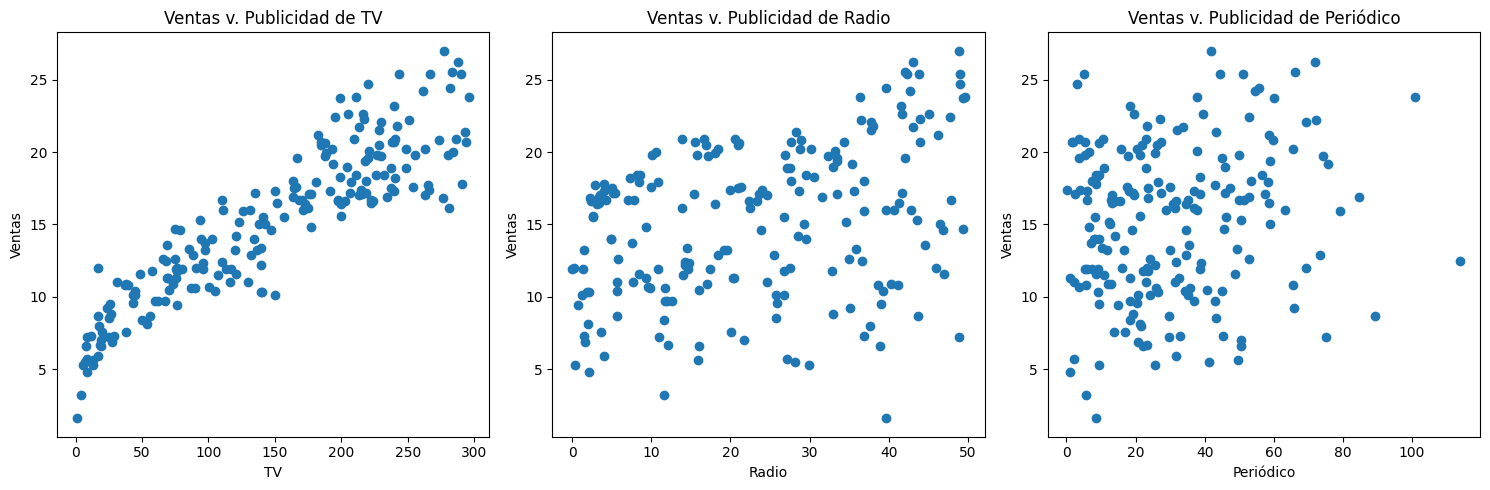

In [32]:
# Visualizar las relaciones entre las características
fig, axes = plt.subplots(1,3,figsize=(15,5))

# Ventas v. TV
axes[0].scatter(data['TV'], data['Sales'])
axes[0].set_title('Ventas v. Publicidad de TV')
axes[0].set_xlabel('TV')
axes[0].set_ylabel('Ventas')

# Ventas v. Radio
axes[1].scatter(data['Radio'], data['Sales'])
axes[1].set_title('Ventas v. Publicidad de Radio')
axes[1].set_xlabel('Radio')
axes[1].set_ylabel('Ventas')

# Ventas v. Periódico
axes[2].scatter(data['Newspaper'], data['Sales'])
axes[2].set_title('Ventas v. Publicidad de Periódico')
axes[2].set_xlabel('Periódico')
axes[2].set_ylabel('Ventas')

plt.tight_layout()
plt.show()

## Modelado

In [33]:
# Dividir los datos
X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
# Construir el modelo de regresión 
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

# Verificar qué variables son significativas
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     405.2
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           1.36e-67
Time:                        19:04:58   Log-Likelihood:                -272.35
No. Observations:                 140   AIC:                             552.7
Df Residuals:                     136   BIC:                             564.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6614      0.368     12.650      0.0

## Evaluación

Ya que la variable Newspaper no parece significativa, se quita del modelo.

In [35]:
X_train = X_train[['const', 'TV', 'Radio']] # Quitando Newspaper
new_model = sm.OLS(y_train, X_train).fit()

In [36]:
X_test = sm.add_constant(X_test)
y_pred = new_model.predict(X_test[['const', 'TV', 'Radio']])

In [37]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_cuad = r2_score(y_test, y_pred)
print('Error Absoluto Medio:', mae)
print('Error Media Cuadrada:', mse)
print('R-cuadrado:', r_cuad)

Error Absoluto Medio: 1.1919753277836762
Error Media Cuadrada: 2.3645069433762367
R-cuadrado: 0.9073562242286407


Conclusiones: MAE y MSE bajos, y R-cuadrado cerca de 1 indican un modelo bien ajustado.

## Intervalos de Confianza

In [42]:
# Calcular los intervalos de confianza con datos ingesados
# Crear DataFrame con nuevos datos
new_data = pd.DataFrame({'const': [1], 'TV': [100], 'Radio':[50], 'Newspaper':[70]})

prediccion = new_model.get_prediction(new_data[['const', 'TV', 'Radio']]) # Newspaper excluido



In [43]:
# Calcular el intervalo de confianza de 90%
intervalo_confianza = prediccion.conf_int(alpha=0.1) 
print(intervalo_confianza)

[[14.71820447 15.72514686]]


## Validación de Supuestos

### 1. Linealidad

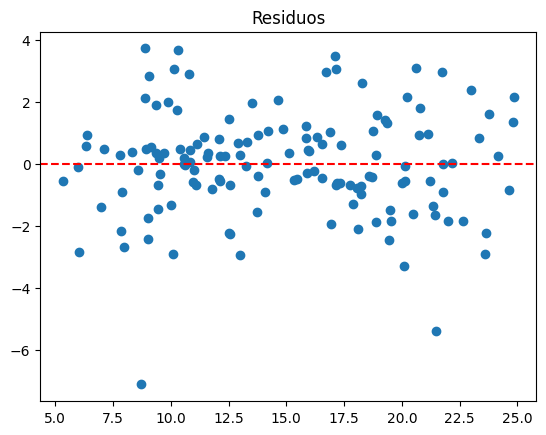

In [49]:
# Calcular los residuos
y_train_pred = new_model.predict(X_train)  
Resid = y_train - y_train_pred  

# Visualizar los residuos para detectar patrones
plt.scatter(y_train_pred, Resid) 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Residuos')
plt.show()

Comentario: No hay patrones visibles lo que indica linealidad.

### 2. Normalidad de Residuos

In [58]:
# Cálculo de la asimetría en residuales
skew = float(stats.skew(Resid, bias=True))
skew

-0.5124182186793588

In [59]:
# Cálculo de la curtosis de residuales
kurtosis = float(stats.kurtosis(Resid, fisher=False))
kurtosis

4.782590640126668

In [61]:
# Estadístico Jarque-Bera
Jarque_Bera = (len(Resid) / 6) * (skew ** 2 + ((kurtosis - 3) ** 2) / 4)
Jarque_Bera

24.662861496030988

In [62]:
# Valor crítico del nivel de confianze 90%
valor_critico = stats.chi2.ppf(0.9, df=2)
valor_critico

np.float64(4.605170185988092)

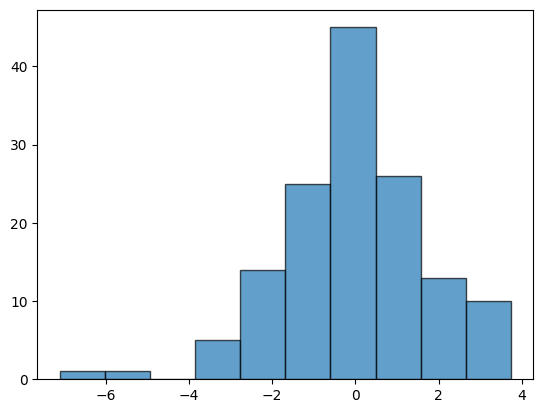

In [65]:
# Verificar la normalidad visualmente

# Histograma de residuales
plt.hist(Resid, bins=10, edgecolor='k', alpha=0.7)
plt.show()


Comentario: Los residuos no se distribuyen normalmente, lo que viola el supuesto de normalidad. Esto es verificado visualmente con un histograma, lo que muestra asimetría a la izquierda.

### 3. Homocedasticidad

In [64]:
white_test = het_white(model.resid, model.model.exog)
print("Estadístico de prueba:", white_test[0])
print("Valor p:", white_test[1])

Estadístico de prueba: 18.179166389781713
Valor p: 0.03315088103033485


Comentario: A un nivel de Alfa=5%, como no tenemos un valor p superior a Alfa, podemos rechazar la hipótesis nula.

### 4. Inexistencia de Autocorrelación 

In [67]:
# Estadístico Durbin-Watson
dw_stat = durbin_watson(Resid)
print("Estadístico Durbin-Watson:", dw_stat)

Estadístico Durbin-Watson: 2.0375161916374998


Comentario: Un valor cerca de 2 indica que no autocorrelación existe en este modelo.

In [70]:

# Calcular el VIF para cada variable independiente
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data

,Variable,VIF
0,const,5.867148
1,TV,1.001352
2,Radio,1.001352


Comentario: Valores bajos de VIF no sugieron correlación entre variables independientes.

## Conclusiones
1. Significancia y Ajusto
- Estadístico F pequeño indica un modelo significante.
- R-cuadrado cerca de 1 indica un modelo bien ajustado.

2. Supuestos
- Prueba Jarque-Bera muestra que los residuos no se distribuyen normalmente, lo que viola un supuesto.
- Prueba White muestra evidencia de heterocedasticidad, lo que viola un supuesto.

A continuar, hay que abordar la heterocedasticidad mediante una transformación de la variable dependiente, después de lo cual el modelo puede ajustarse nuevamente.